In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [81]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [23]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [153]:
print(test_df.shape)
test_df.head()

(418, 12)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Status
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [112]:
def preprocess_data(df, scale=False):
    # Filling missing ages
    male_age = df.groupby('Sex')['Age'].mean()['male']
    female_age = df.groupby('Sex')['Age'].mean()['female']
    df.loc[(df.Sex=='male') & (df.Age.isnull()), 'Age'] = male_age
    df.loc[(df.Sex=='female') & (df.Age.isnull()), 'Age'] = female_age
    #Retrieving info about a person
    df['Status'] = df['Name'].apply(lambda x: get_status(x)).fillna('Mr')
    features2encode = df['Status'].values.reshape(-1,1)
    enc_status = pd.DataFrame(OneHotEncoder(drop='first', sparse_output=False).fit_transform(features2encode))
    df = pd.concat([df, enc_status], axis=1)
    #Dropping columns
    df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Status'])
    #Filling na and Encoding
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    df['Embarked'] = df['Embarked'].fillna('S')
    df['Embarked'] = df['Embarked'].map({'S':2,'C':1,'Q':0})
    df.columns = df.columns.astype(str)
    if scale:
        df_scaled = MinMaxScaler().fit_transform(df)
        return df_scaled
    return df

def get_status(name: str):
    status = {'Mr': 'Mr.', 'Mrs': 'Mrs.', 'Miss': ['Miss.', 'Ms.'], 'Master': 'Master.', 'Dr': 'Dr.', 'Rev': 'Rev.'}
    name = name.split(' ')
    for key, value in status.items():
        if type(value)==str:
            if value in name:
                return key
        else:
            for v in value:
                if v in name:
                    return key


In [113]:
df = preprocess_data(train_df, scale=False)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,0,1,2,3,4
0,0,3,0,22.000000,1,0,7.2500,2,0.0,0.0,1.0,0.0,0.0
1,1,1,1,38.000000,1,0,71.2833,1,0.0,0.0,0.0,1.0,0.0
2,1,3,1,26.000000,0,0,7.9250,2,0.0,1.0,0.0,0.0,0.0
3,1,1,1,35.000000,1,0,53.1000,2,0.0,0.0,0.0,1.0,0.0
4,0,3,0,35.000000,0,0,8.0500,2,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.000000,0,0,13.0000,2,0.0,0.0,0.0,0.0,1.0
887,1,1,1,19.000000,0,0,30.0000,2,0.0,1.0,0.0,0.0,0.0
888,0,3,1,27.915709,1,2,23.4500,2,0.0,1.0,0.0,0.0,0.0
889,1,1,0,26.000000,0,0,30.0000,1,0.0,0.0,1.0,0.0,0.0


In [114]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
0           0
1           0
2           0
3           0
4           0
dtype: int64

<Axes: title={'center': 'Pearson Correlation of Features'}>

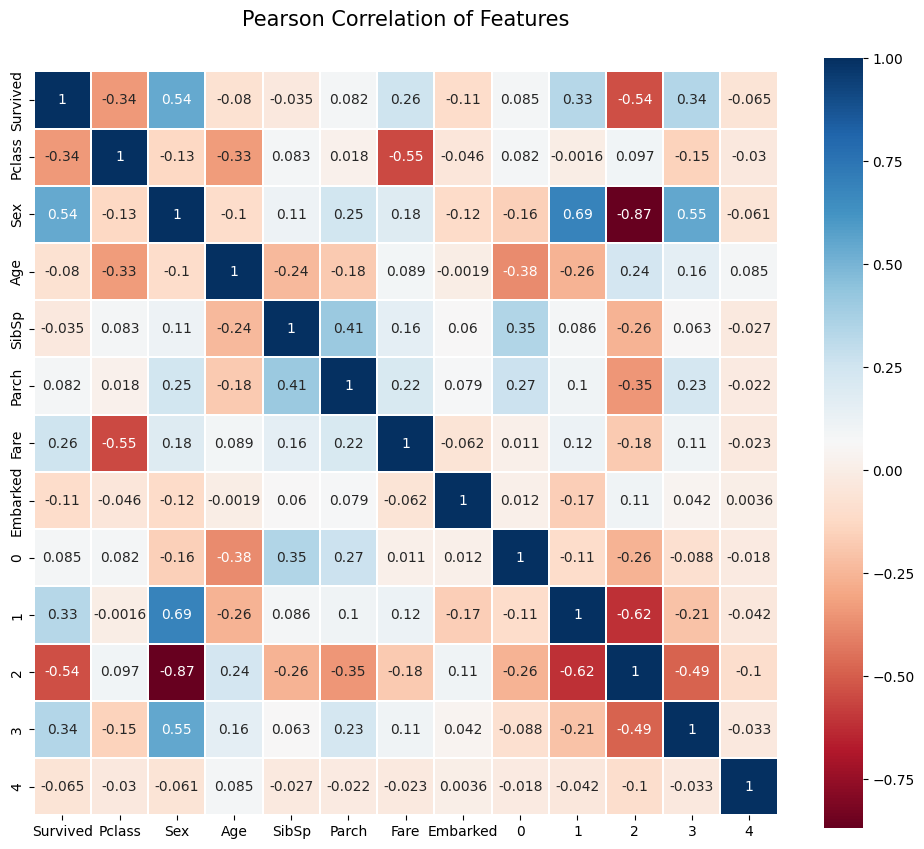

In [115]:
colormap = plt.cm.RdBu
plt.figure(figsize=(12,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [116]:
df = preprocess_data(train_df, scale=True)
df.shape

(891, 13)

In [117]:
X_scaled = df[:, 1:]
y = df[:, 0]

pd.DataFrame(X_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.0,0.271174,0.125,0.000000,0.014151,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.472229,0.125,0.000000,0.139136,0.5,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.321438,0.000,0.000000,0.015469,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.434531,0.125,0.000000,0.103644,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.434531,0.000,0.000000,0.015713,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.5,0.0,0.334004,0.000,0.000000,0.025374,1.0,0.0,0.0,0.0,0.0,1.0
887,0.0,1.0,0.233476,0.000,0.000000,0.058556,1.0,0.0,1.0,0.0,0.0,0.0
888,1.0,1.0,0.345510,0.125,0.333333,0.045771,1.0,0.0,1.0,0.0,0.0,0.0
889,0.0,0.0,0.321438,0.000,0.000000,0.058556,0.5,0.0,0.0,1.0,0.0,0.0


In [118]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=2)
# Splitting data for training base and training meta
x_train, x_meta, y_train, y_meta = train_test_split(X_train, Y_train, test_size=0.3, random_state=3)

In [119]:
def eval_model(y_true, y_pred, model):
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(model)
    plt.show()
    print(f'Recall: {recall_score(y_true, y_pred)}')
    print(f'Precision: {precision_score(y_true, y_pred)}')
    print(f'Accuracy: {accuracy_score(y_true, y_pred)}')

In [133]:
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
lr = LogisticRegression()
gnb = GaussianNB()
models = [knn, dtc, lr, gnb]

param_grids = [
    {'n_neighbors': range(1, 8),
    'weights': ('uniform', 'distance')},
    {'criterion': ('gini', 'entropy', 'log_loss'),
     'max_depth': range(1,10)},
    {'penalty': ('l2', None),
     'max_iter': [200],
     'C': (1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4)},
    {}
]
best_params = []
param_grids

[{'n_neighbors': range(1, 8), 'weights': ('uniform', 'distance')},
 {'criterion': ('gini', 'entropy', 'log_loss'), 'max_depth': range(1, 10)},
 {'penalty': ('l2', None),
  'max_iter': [200],
  'C': (1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4)},
 {}]

In [134]:
for n, model in enumerate(models):
    grid = GridSearchCV(model, param_grids[n], scoring='accuracy', cv=3)
    grid.fit(x_train, y_train)
    best_params.append(grid.best_params_)

/home/scorpgodwest/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/scorpgodwest/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/scorpgodwest/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/scorpgodwest/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/scorpgodwest/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/scorpgodwest/.local/lib/python3.10/site-packages/sklea

In [135]:
best_params

[{'n_neighbors': 6, 'weights': 'uniform'},
 {'criterion': 'gini', 'max_depth': 3},
 {'C': 1, 'max_iter': 200, 'penalty': 'l2'},
 {}]

In [136]:
sum(x_train==np.nan)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

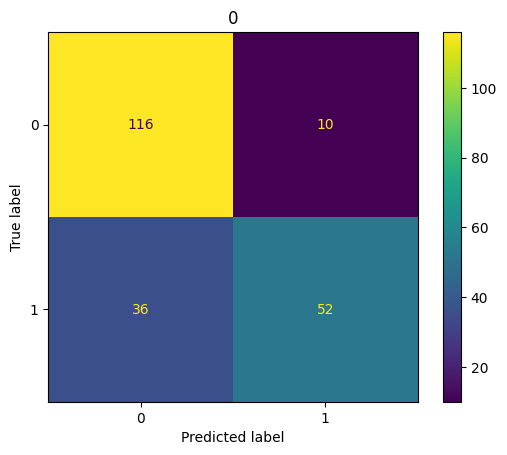

Recall: 0.5909090909090909
Precision: 0.8387096774193549
Accuracy: 0.7850467289719626


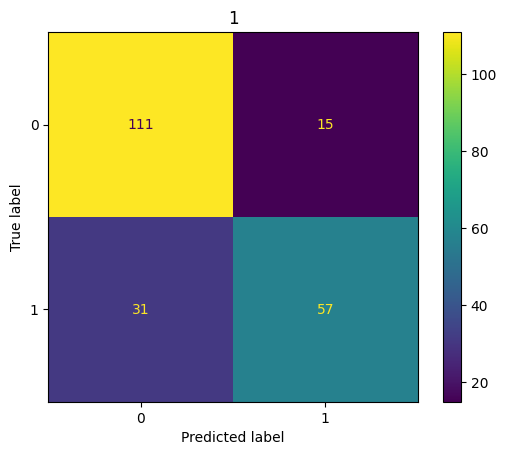

Recall: 0.6477272727272727
Precision: 0.7916666666666666
Accuracy: 0.7850467289719626


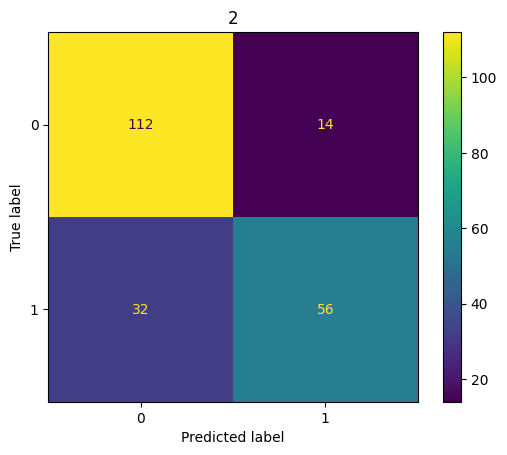

Recall: 0.6363636363636364
Precision: 0.8
Accuracy: 0.7850467289719626


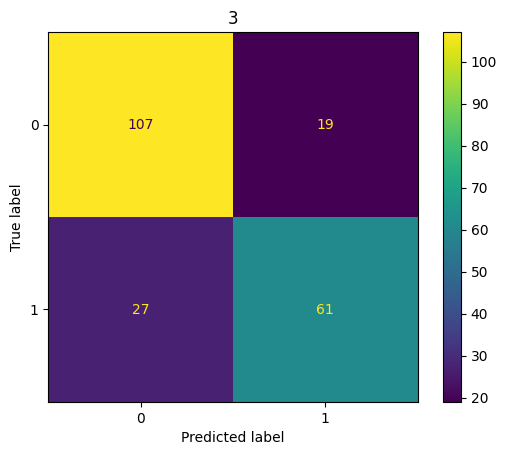

Recall: 0.6931818181818182
Precision: 0.7625
Accuracy: 0.7850467289719626


In [137]:
models[0] = KNeighborsClassifier(n_neighbors=6, weights='uniform').fit(x_train, y_train)
models[1] = DecisionTreeClassifier(criterion='gini', max_depth=3).fit(x_train, y_train)
models[2] = LogisticRegression(penalty='l2', max_iter=200, C=1).fit(x_train, y_train)
models[3] = GaussianNB().fit(x_train, y_train)

meta_mtrx_train = np.empty((x_meta.shape[0], len(models)))
meta_mtrx_test = np.empty((X_test.shape[0], len(models)))
for n, model in enumerate(models):
    models[n] = model.fit(x_train, y_train)
    meta_mtrx_train[:, n] = models[n].predict(x_meta)
    meta_mtrx_test[:, n] = models[n].predict(X_test)
    eval_model(y_meta, meta_mtrx_train[:, n], n)

In [138]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_params = {
    'n_estimators': range(1, 20),
    'max_depth': range(1, 20),
    'eta': (0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8) 
}

meta = XGBClassifier()
grid = GridSearchCV(meta, xgb_params, cv=3).fit(meta_mtrx_train, y_meta)
grid.best_params_

{'eta': 0.4, 'max_depth': 1, 'n_estimators': 5}

In [139]:
meta = XGBClassifier(eta=0.4, max_depth=1, n_estimators=5).fit(meta_mtrx_train, y_meta)
y_pred = meta.predict(meta_mtrx_test)

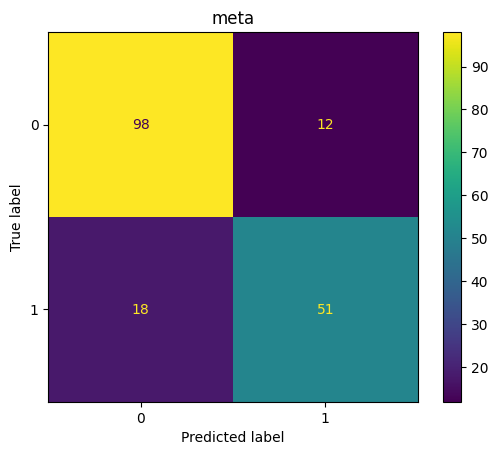

Recall: 0.7391304347826086
Precision: 0.8095238095238095
Accuracy: 0.8324022346368715


In [140]:
eval_model(Y_test, y_pred, 'meta')

In [143]:
test_scaled = preprocess_data(test_df)
meta_data = np.empty((test_df.shape[0], len(models)))
for n, model in enumerate(models):
    meta_data[:, n] = models[n].predict(test_scaled)

y_pred = meta.predict(meta_data)
y_pred

/home/scorpgodwest/.local/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/home/scorpgodwest/.local/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/scorpgodwest/.local/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/scorpgodwest/.local/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,

In [152]:
result = pd.concat([test_df.PassengerId, pd.Series(y_pred, name='Survived')], axis=1)
print(result.shape)
result.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [150]:
result.to_csv('result', index=False)